In [1]:
# importing required libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from nltk.corpus import  stopwords
import string
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score,classification_report,roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
import warnings
from sklearn.calibration import CalibratedClassifierCV
import re
from sklearn.preprocessing import LabelEncoder
from scipy import stats 
warnings.simplefilter(action='ignore', category=FutureWarning)
sb.set()

In [2]:
# loading data
data = pd.read_csv(r'C:\Users\91743\Desktop\Fake_news_project\train_news.csv')

In [3]:
data

Unnamed: 0     id                                           headline  \
0               0   9653  Ethics Questions Dogged Agriculture Nominee as...   
1               1  10041  U.S. Must Dig Deep to Stop Argentina’s Lionel ...   
2               2  19113  Cotton to House: ’Do Not Walk the Plank and Vo...   
3               3   6868  Paul LePage, Besieged Maine Governor, Sends Co...   
4               4   7596                       A Digital 9/11 If Trump Wins   
...           ...    ...                                                ...   
20795       20795   5671                                                NaN   
20796       20796  14831        Albert Pike and the European Migrant Crisis   
20797       20797  18142  Dakota Access Caught Infiltrating Protests to ...   
20798       20798  12139  How to Stretch the Summer Solstice - The New Y...   
20799       20799  15660  Emory University to Pay for ’100 Percent’ of U...   

                       written_by  \
0      Eric Lipton and Steve Eder   
1                 David Waldstein   
2                         Pam Key   
3                    Jess Bidgood   
4               Finian Cunningham   
...                           ...   
20795              NeverSurrender   
20796               Rixon Stewart   
20797                 Eddy Lavine   
20798              Alison S. Cohn   
20799                Tom Ciccotta   

                                                    news  label  
0      WASHINGTON  —   In Sonny Perdue’s telling, Geo...      0  
1      HOUSTON  —   Venezuela had a plan. It was a ta...      0  
2      Sunday on ABC’s “This Week,” while discussing ...      0  
3      AUGUSTA, Me.  —   The beleaguered Republican g...      0  
4        Finian Cunningham has written extensively on...      1  
...                                                  ...    ...  
20795  No, you'll be a dog licking of the vomit of yo...      1  
20796  By Rixon Stewart on November 5, 2016 Rixon Ste...      1  
20797  posted by Eddie You know the Dakota Access Pip...      1  
20798  It’s officially summer, and the Society Boutiq...      0  
20799  Emory University in Atlanta, Georgia, has anno...      0  

[20800 rows x 6 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20800 non-null  int64 
 1   id          20800 non-null  int64 
 2   headline    20242 non-null  object
 3   written_by  18843 non-null  object
 4   news        20761 non-null  object
 5   label       20800 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 975.1+ KB


In [5]:
# checking for null values
data.isnull().sum()

Unnamed: 0       0
id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64

In [6]:
# replacing null values with empty string
data.fillna('',inplace =True)

In [7]:
# defining function to apply chi-squared test of independence
def apply_chi2_test(feature, target):
    df=pd.crosstab(data[feature],data[target]) # creates contingency table/frequency distribution of observed values

    Observed_Values = df.values     # Observed Values
    val=stats.chi2_contingency(df)

    Expected_Values = val[3]  #  Expected values
    
    chi_square_statistic=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)]).sum() # calculates chi2 statistics
    
    no_of_rows=len(df.iloc[0:,0]) # no. of rows in a contingency table
    no_of_columns=len(df.iloc[0,0:]) # no. of columns in a contingency table
    ddof=(no_of_rows-1)*(no_of_columns-1) # degree of freedom for the test
    alpha = 0.05 # defining significance level
    
    critical_value=stats.chi2.ppf(q=1-alpha,df=ddof) # calculates critical value from chi2 distribution
    
    if chi_square_statistic>=critical_value: # check if chi2 statistics is greater than critical_value
        return print(f"Hull hypothesis rejected, there is a significant relationship between columns '{feature}' and target '{target}'")
    else:
        return print(f"Hull hypothesis accepted,There no significant relationship between columns '{feature}' and ' target {target}'")    

In [8]:
# applying chi-squared of independence between columns 'written_by'  and 'label'
apply_chi2_test('written_by', 'label')

Hull hypothesis rejected, there is a significant relationship between columns 'written_by' and target 'label'


In [9]:
# applying chi-squared of independence between columns 'headline'  and 'label'
apply_chi2_test('headline', 'label')

Hull hypothesis rejected, there is a significant relationship between columns 'headline' and target 'label'


In [10]:
# combining columns 'headline','written_by' and 'news' to get complete 'text' column for each instance
data['text'] = data['headline'] + ' '+ data['written_by'] + ' '+ data['news']

In [11]:
# creating new columns for length of both 'headline' and 'news'
data['headline_length'] = data['headline'].str.len()
data['news_length'] = data['news'].str.len()

In [12]:
data

Unnamed: 0     id                                           headline  \
0               0   9653  Ethics Questions Dogged Agriculture Nominee as...   
1               1  10041  U.S. Must Dig Deep to Stop Argentina’s Lionel ...   
2               2  19113  Cotton to House: ’Do Not Walk the Plank and Vo...   
3               3   6868  Paul LePage, Besieged Maine Governor, Sends Co...   
4               4   7596                       A Digital 9/11 If Trump Wins   
...           ...    ...                                                ...   
20795       20795   5671                                                      
20796       20796  14831        Albert Pike and the European Migrant Crisis   
20797       20797  18142  Dakota Access Caught Infiltrating Protests to ...   
20798       20798  12139  How to Stretch the Summer Solstice - The New Y...   
20799       20799  15660  Emory University to Pay for ’100 Percent’ of U...   

                       written_by  \
0      Eric Lipton and Steve Eder   
1                 David Waldstein   
2                         Pam Key   
3                    Jess Bidgood   
4               Finian Cunningham   
...                           ...   
20795              NeverSurrender   
20796               Rixon Stewart   
20797                 Eddy Lavine   
20798              Alison S. Cohn   
20799                Tom Ciccotta   

                                                    news  label  \
0      WASHINGTON  —   In Sonny Perdue’s telling, Geo...      0   
1      HOUSTON  —   Venezuela had a plan. It was a ta...      0   
2      Sunday on ABC’s “This Week,” while discussing ...      0   
3      AUGUSTA, Me.  —   The beleaguered Republican g...      0   
4        Finian Cunningham has written extensively on...      1   
...                                                  ...    ...   
20795  No, you'll be a dog licking of the vomit of yo...      1   
20796  By Rixon Stewart on November 5, 2016 Rixon Ste...      1   
20797  posted by Eddie You know the Dakota Access Pip...      1   
20798  It’s officially summer, and the Society Boutiq...      0   
20799  Emory University in Atlanta, Georgia, has anno...      0   

                                                    text  headline_length  \
0      Ethics Questions Dogged Agriculture Nominee as...               84   
1      U.S. Must Dig Deep to Stop Argentina’s Lionel ...               72   
2      Cotton to House: ’Do Not Walk the Plank and Vo...              100   
3      Paul LePage, Besieged Maine Governor, Sends Co...              100   
4      A Digital 9/11 If Trump Wins Finian Cunningham...               28   
...                                                  ...              ...   
20795   NeverSurrender No, you'll be a dog licking of...                0   
20796  Albert Pike and the European Migrant Crisis Ri...               43   
20797  Dakota Access Caught Infiltrating Protests to ...               84   
20798  How to Stretch the Summer Solstice - The New Y...               55   
20799  Emory University to Pay for ’100 Percent’ of U...               93   

       news_length  
0             7936  
1             6112  
2              425  
3             6516  
4             9164  
...            ...  
20795           69  
20796         6621  
20797         3433  
20798         2334  
20799         1932  

[20800 rows x 9 columns]

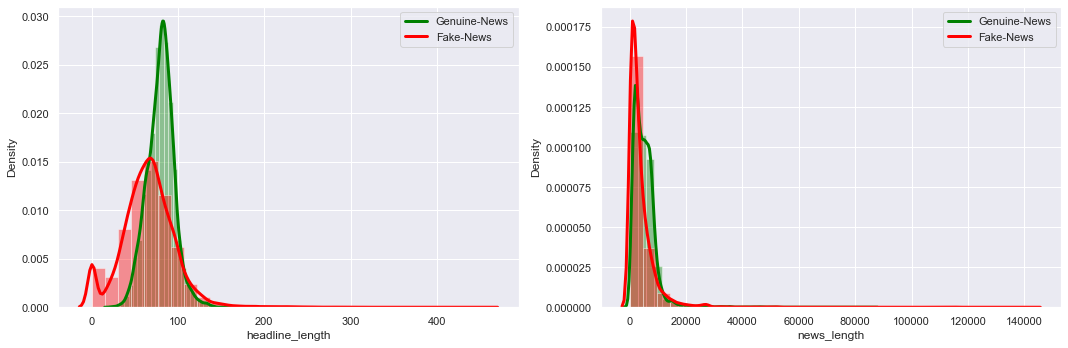

In [13]:
# plotting distribution curve for headline and news lengths with respect to Genuine and Fake news
for i, col in enumerate(['headline_length','news_length']):    
    plt.subplot(1,2, i+1)

    sb.distplot(data[col][data['label'] == 0], kde = True, bins = 30 , color = 'green', kde_kws=dict(linewidth=3)) # plotting for Genuine news
    sb.distplot(data[col][data['label'] == 1], kde = True, bins = 30, color = 'red',kde_kws=dict(linewidth=3)) # plotting for Fake news
    plt.legend(['Genuine-News','Fake-News']) # defining plot legend
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(15,5)
    plt.tight_layout()
plt.show()

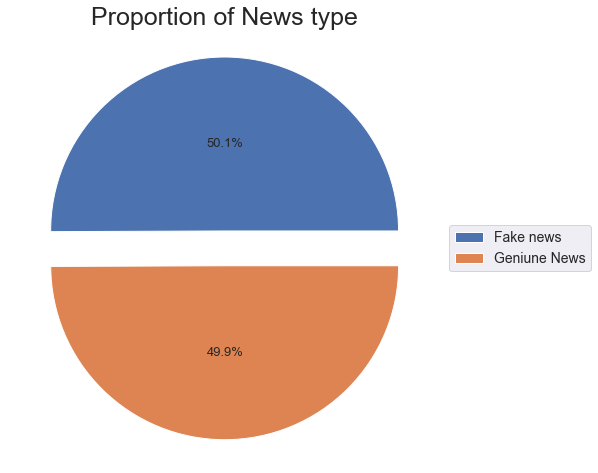

In [14]:
# pie-plot to represent the proportion of target column 
plt.figure(figsize = (10,8))
wedges, texts, autotexts = plt.pie(data.label.value_counts(), autopct="%.1f%%", 
                                   explode=[0.1]*2, pctdistance=0.5) # defining pie chart
plt.legend(wedges,['Fake news','Geniune News'],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), prop = {'size':14}, fontsize = 20) # defining plot legend
plt.setp(autotexts, size = 13)
plt.title('Proportion of News type', fontsize = 25 )
plt.show()

In [15]:
# creating class to pre-process textual data
class Text_Preprocessor:
    def __init__(self, data):
        self.data = data # class attribute as input data to be cleaned
        self.cleaned_text = pd.Series(dtype = str) # initializing class attribute 'cleaned_text' to empty series
    
    # function to clean text
    def clean_text(self):

        if type(self.data) != str: # checking if data is not sting type

            text = [self.tokenize_and_clean(text) for text in self.data] # creating list of cleaned text by calling function 'tokenize_and_clean'
            self.cleaned_text =  pd.Series(text) 
        
        else: # if data is string type
            self.cleaned_text = '' # initializing to empty string
            self.cleaned_text = self.tokenize_and_clean(self.data) # clean the text
        print('<...Data Cleaned...>')
        
        
        
    # function to tokenize and clean data
    def tokenize_and_clean(self,text):
        words = [WordNetLemmatizer().lemmatize(word.lower()) for word in text.split() if word.lower()
                 not in stopwords.words('english') and len(word)>=3] # splitting, lower casing, excluding stopwords and word length less than 3 for the input text and forming a list of filtered words
        
        text = ' '.join(words) # joining words from the list
        text = re.sub(r'http\S+', '', text) # replacing hyperlinks by empty string
        text = text.translate(str.maketrans('', '', string.punctuation)) # replacing punctuations by empty string
        text = re.sub(' \d+', '',  text) # replacing digits by empty string
        return text

    # function to fit tfidf vectorizer
    def fit_tfidf(self):
        global tfidf # defining tfidf variable as global
        tfidf = TfidfVectorizer(analyzer = 'word',ngram_range = (1,3), max_features = 14500) # initializing tfidf
        tfidf.fit(self.cleaned_text) # fitting tfidf
        print('<...TF-IDF fitted...>')
        
            
    # function to transform or vectorize the cleaned data
    def vectorize(self,data):
        if type(self.data) == str: # checking if data is string type
            return tfidf.transform([self.cleaned_text])
        else:
            return tfidf.transform(self.cleaned_text)

In [16]:
# train-test split
xtrain, xtest, ytrain, ytest   = train_test_split(data['text'], data['label'],
                                                    stratify = data['label'],
                                                    test_size = 0.3,
                                                    random_state = 0)

In [24]:
%%time
# cleaning the training data using Text Preprocessing class
xtrain_preprocess = Text_Preprocessor(xtrain)
xtrain_preprocess.clean_text()

<...Data Cleaned...>
Wall time: 34min 53s


In [26]:
# getting cleaned data using class attribute
xtrain_cleaned = xtrain_preprocess.cleaned_text

In [40]:
# changing name to 'Cleaned_text'
xtrain_cleaned.name = 'Cleaned_text'

In [19]:
df_word_cloud = pd.concat([xtrain_cleaned,ytrain.reset_index(drop=True)],1)

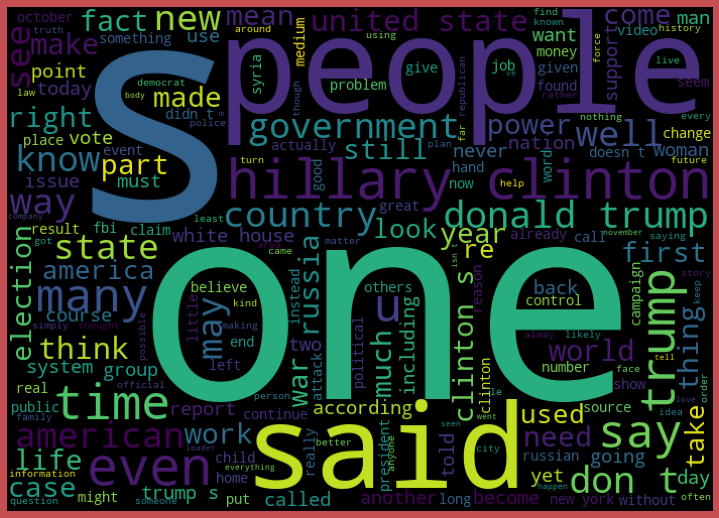

In [22]:
# visualizing most frequent words in Normal comments
df = df_word_cloud['Cleaned_text'][df_word_cloud['label']==1] # fake news data

spam_cloud = WordCloud(width=700,height=500,background_color='black').generate(' '.join(df)) # initializing word cloud
# plotting word cloud
plt.figure(figsize=(10,7),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

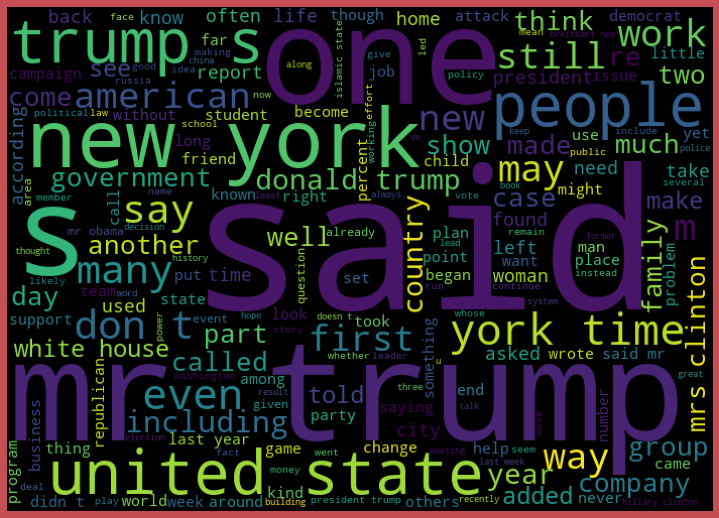

In [21]:
# visualizing most frequent words in Normal comments
df = df_word_cloud['Cleaned_text'][df_word_cloud['label']==0] # genuine news data

spam_cloud = WordCloud(width=700,height=500,background_color='black').generate(' '.join(df)) # initializing word cloud
# plotting word cloud
plt.figure(figsize=(10,7),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [72]:
# fitting TF-IDF on training data
xtrain_preprocess.fit_tfidf()

<...TF-IDF fitted...>


In [74]:
# transforming the training data using fitted TF-IDF
xtrain_vec = xtrain_preprocess.vectorize(xtrain_cleaned)

In [23]:
# function to compute cross-validation result for each model
def cross_validation(models, model_name, title):
    scores = [] # initializing score list
    for model in models: # iterating over models

        score = cross_val_score(model, xtrain_vec, ytrain.values, cv = 5 , scoring = 'accuracy', n_jobs = -1 ) # compute score for each fold
        mean_score = score.mean() # average score
        std_score = score.std() # standard deviation in score
        
        print('model: {}'.format(model))
        print('CV score:{}'.format(mean_score))
        print('score_std:',std_score)
        print('----------')
        scores.append(score)
    # plotting boxplots for visual analysis of the result
    fig = plt.figure()
    fig.suptitle(title, fontsize = 18)
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(model_name,
                      fontsize = 16)

    plt.ylabel('CV score', fontsize = 14)
    fig.set_size_inches(16,7)
    plt.show() 

model: LinearSVC()
CV score:0.9741071428571428
score_std: 0.002284105652241186
----------
model: MultinomialNB()
CV score:0.9230082417582416
score_std: 0.0038571761214557967
----------
model: RandomForestClassifier()
CV score:0.970260989010989
score_std: 0.002575320502644589
----------
model: AdaBoostClassifier()
CV score:0.9688873626373626
score_std: 0.002284105652241186
----------


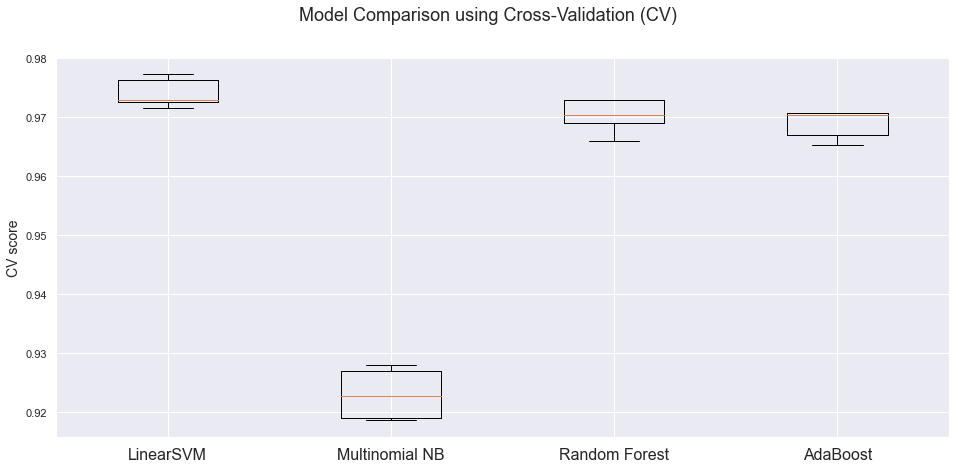

In [24]:
# initializing each model
mnb = MultinomialNB()
lsvm = LinearSVC()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
model_name = ['LinearSVM','Multinomial NB', 'Random Forest','AdaBoost'] # model name
title = 'Model Comparison using Cross-Validation (CV)' # plot title
models = [lsvm, mnb, rf, ada] # model list
cross_validation(models, model_name, title) # computing cross-validation results

In [25]:
print('*******TRAIN RESULTS*******')
print('\n')

for model in models: # iterating over models for training
    model.fit(xtrain_vec, ytrain) # fitting data
    ypred = model.predict(xtrain_vec) # predicting data
    
    # displaying training performance metrics
    print('Model:',model,'\n')
    print('accuracy:',round(accuracy_score(ytrain, ypred)*100,2),'%','\n')
    print('f1_score:',round(f1_score(ytrain,ypred)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(ytrain, ypred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TRAIN RESULTS*******


Model: LinearSVC() 

accuracy: 99.93 % 

f1_score: 99.93 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7271
           1       1.00      1.00      1.00      7289

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560

------------------------------------------------------------------------------


Model: MultinomialNB() 

accuracy: 93.98 % 

f1_score: 93.87 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      7271
           1       0.96      0.92      0.94      7289

    accuracy                           0.94     14560
   macro avg       0.94      0.94      0.94     14560
weighted avg       0.94      0.94      0.94     14560

-----------------------------------------------------------

In [24]:
%%time
# pre-processing testing data using Text Preprocessor class
xtest_preprocess = Text_Preprocessor(xtest)
xtest_preprocess.clean_text()
xtest_vec = xtest_preprocess.vectorize(xtest)

<...Data Cleaned...>
Wall time: 15min 21s


In [28]:
# defining function to display performance metrics
def show_test_metrics(model, show_roc_auc = True):
    print('Model:',model,'\n')
    print('accuracy:',round(accuracy_score(ytest, ypred)*100,2),'%','\n')
    print('recall_score :', round(recall_score(ytest,ypred)*100,2),'%','\n')
    print('precision_score :', round(precision_score(ytest,ypred)*100,2),'%','\n')
    print('f1_score:',round(f1_score(ytest,ypred)*100,2),'%','\n')
    if show_roc_auc: # if show roc auc score
            print('roc_auc_score:', round(roc_auc_score(ytest,ypred_proba)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(ytest, ypred))
    print('------------------------------------------------------------------------------')
    print('\n')

In [50]:
print('*******TEST RESULTS********')
print('\n')

for model in models: # iterating over tuned models for testing
    if model == models[0]: # if model is Linear SVC 
        model_prob_pred= CalibratedClassifierCV(tuned_models[0], n_jobs = -1).fit(xtrain_vec, ytrain) # fitting 'CalibratedClassifierCV' for predicting probabilities
        ypred_proba = model_prob_pred.predict_proba(xtest_vec)[:,1] # predicting probabilities
        ypred = model.predict(xtest_vec) # predicting on test data
    else:
        ypred = model.predict(xtest_vec) # predicting on test data
        ypred_proba = model.predict_proba(xtest_vec)[:,1] # predicting probabilities
    show_test_metrics(model) # displaying performance metrics

*******TEST RESULTS********


Model: LinearSVC() 

accuracy: 97.53 % 

recall_score : 97.31 % 

precision_score : 97.75 % 

f1_score: 97.53 % 

roc_auc_score: 99.66 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3116
           1       0.98      0.97      0.98      3124

    accuracy                           0.98      6240
   macro avg       0.98      0.98      0.98      6240
weighted avg       0.98      0.98      0.98      6240

------------------------------------------------------------------------------


Model: MultinomialNB() 

accuracy: 92.07 % 

recall_score : 88.67 % 

precision_score : 95.16 % 

f1_score: 91.8 % 

roc_auc_score: 98.18 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      3116
           1       0.95      0.89      0.92      3124

    accuracy                           0.92      6240
   macro avg 

### Hyper-parameter Tuning

In [29]:
# inilializing the hyper-parameters of each model
param_lsvm = dict(loss= ['hinge', 'squared_hinge'],
                  C = np.linspace(0.1,2, 10),
                  random_state = [0])

param_mnb = dict(alpha = np.linspace(0.01,1, 10))

param_rf = dict(n_estimators = [100,150,250], criterion = ['gini', 'entropy'],
                max_depth = [5,10,20,None], min_samples_leaf = [1,2,3],
                random_state = [0,1,3])

param_ada = dict(n_estimators = [50,75,100,150],
                 learning_rate = [0.01, 0.1, 1],
                 random_state = [0])

In [30]:
model_param_list = [(lsvm, param_lsvm), (mnb, param_mnb), (rf, param_rf), (ada, param_ada)]

In [32]:
%%time
# tuning all models
tuned_models = []
for model, param in model_param_list: # iterating over each model and its parameters for tuning
    
    r_search = RandomizedSearchCV(model, param, cv = 5, n_jobs = -1, scoring = 'accuracy', random_state = 0)
    r_search.fit(xtrain_vec, ytrain) # fitting random search instance
    best_cvscore = r_search.best_score_ # getting best score
    best_param = r_search.best_params_ # getting optimum hyper-parameters
    best_estimator = r_search.best_estimator_ # getting best estimator
    tuned_models.append(best_estimator) # appending tuned model
    
    # displaying status of model tuning
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_parameter:', best_param)
    print('\n')
    
print('tuned_models:',tuned_models)

model: LinearSVC()
best_cvscore: 0.9743818681318681
best_parameter: {'random_state': 0, 'loss': 'squared_hinge', 'C': 1.3666666666666667}


model: MultinomialNB()
best_cvscore: 0.9297390109890111
best_parameter: {'alpha': 0.01}


model: RandomForestClassifier()
best_cvscore: 0.9721153846153847
best_parameter: {'random_state': 3, 'n_estimators': 250, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}


model: AdaBoostClassifier()
best_cvscore: 0.9773351648351648
best_parameter: {'random_state': 0, 'n_estimators': 150, 'learning_rate': 1}


tuned_models: [LinearSVC(C=1.3666666666666667, random_state=0), MultinomialNB(alpha=0.01), RandomForestClassifier(n_estimators=250, random_state=3), AdaBoostClassifier(learning_rate=1, n_estimators=150, random_state=0)]
Wall time: 9min 11s


In [33]:
print('*******TEST RESULTS AFTER HYPER-PARAMETER TUNING********')
print('\n')

for model in tuned_models: # iterating over tuned models for testing
    if model == tuned_models[0]: # if model is Linear SVC 
        model_prob_pred= CalibratedClassifierCV(tuned_models[0], n_jobs = -1).fit(xtrain_vec, ytrain) # fitting 'CalibratedClassifierCV' for predicting probabilities
        model.fit(xtrain_vec, ytrain) # fitting model
        ypred_proba = model_prob_pred.predict_proba(xtest_vec)[:,1] # predicting probabilities
        ypred = model.predict(xtest_vec) # predicting on test data
    else:
        model.fit(xtrain_vec, ytrain) # fitting model
        ypred = model.predict(xtest_vec) # predicting on test data
        ypred_proba = model.predict_proba(xtest_vec)[:,1] # predicting probabilities
    show_test_metrics(model) # displaying performance metrics

*******TEST RESULTS AFTER HYPER-PARAMETER TUNING********


Model: LinearSVC(C=1.3666666666666667, random_state=0) 

accuracy: 97.52 % 

recall_score : 97.31 % 

precision_score : 97.72 % 

f1_score: 97.51 % 

roc_auc_score: 99.66 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3116
           1       0.98      0.97      0.98      3124

    accuracy                           0.98      6240
   macro avg       0.98      0.98      0.98      6240
weighted avg       0.98      0.98      0.98      6240

------------------------------------------------------------------------------


Model: MultinomialNB(alpha=0.01) 

accuracy: 93.12 % 

recall_score : 89.88 % 

precision_score : 96.13 % 

f1_score: 92.9 % 

roc_auc_score: 98.54 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      3116
           1       0.96      0.90      0.93    

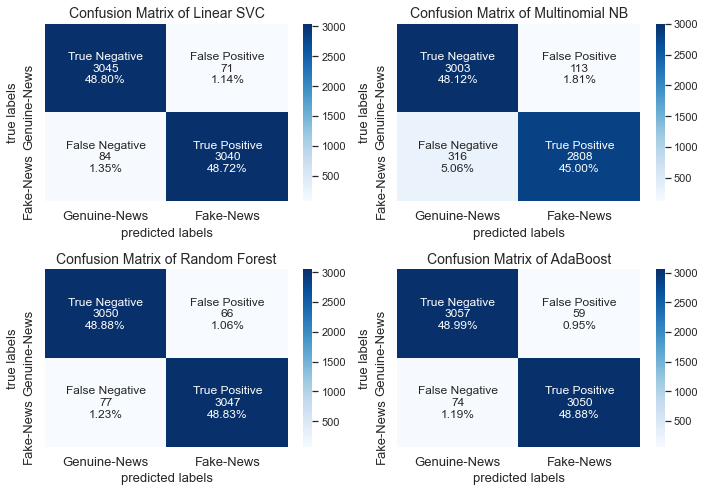

In [42]:
# visualizing confusion matrix  with the help of heatmaps.
model_index = [0,1,2,3] # model index
model_name = ['Linear SVC', 'Multinomial NB', 'Random Forest', 'AdaBoost'] # model name

for index ,model, model_name in zip(model_index,tuned_models,model_name): # iterating over each model to plot confusion maxtrix
    plt.subplot(2,2, index + 1 ) # subplots for each confusion matrix
    ypred = model.predict(xtest_vec) # predicting the test data
    c_matric = confusion_matrix(ytest, ypred) # initailizing confusion matrix
    groups = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in c_matric.flatten()] # count for each cell of confusion matrix  
    group_percent = ['{0:.2%}'.format(value) for value in c_matric.flatten()/np.sum(c_matric)] # calculating percent in each cell
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(groups,group_counts,group_percent)] # organizing labels to plot on the confusion matrix
    labels = np.asarray(labels).reshape(2,2) # reshaping
    sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues') # plotting heatmap
    plt.title('Confusion Matrix of ' + model_name, fontsize = 14)  # setting title
    plt.ylabel('true labels', fontsize = 13) # plotting x label
    plt.xlabel('predicted labels', fontsize = 13) # plotting y label
    fig, ax = plt.gcf(), plt.gca()
    ax.set_xticklabels(['Genuine-News','Fake-News'], fontdict = {'fontsize':13}) # plotting x tick label
    ax.set_yticklabels(['Genuine-News','Fake-News'], fontdict = {'fontsize':13}) # plotting y tick label
    fig.set_size_inches(10, 7) # setting figure size
    plt.tight_layout()
plt.show()

In [51]:
# defining stacked model
def stacked_model(predict = False):
    global stacked_clf # defining stacked_clf variable as global
    if predict: # check if model is fitted for prediction
        return stacked_clf
    else:  # if model is not fitted
        base_models = [] # initializing list for appending base models
        base_models.append(('LinearSVC', tuned_models[0])) # appending LinearSVC as base model
        base_models.append(('Multinomial NB', tuned_models[1])) # appending Multinomial NB as base model
        base_models.append(('Random Forest', tuned_models[2]))# appending Random Forest as base model
        base_models.append(('AdaBoost', tuned_models[3]))# appending AdaBoost as base model

    final_model = tuned_models[0] # appending LinearSVC as the final model to estimate the output of stacked model
    
    stacked_clf = StackingClassifier(estimators=base_models,final_estimator = final_model , cv = 5,n_jobs=-1) # initializing stacked model    
    return stacked_clf

In [53]:
stacked_model().fit(xtrain_vec, ytrain) # fitting stacked model
ypred = stacked_model(predict = True).predict(xtest_vec) # predicting with the help of fitted stacked model
show_test_metrics('Stacked Model', show_roc_auc = False) # display performance metrics

Model: Stacked Model 

accuracy: 98.45 % 

recall_score : 98.3 % 

precision_score : 98.59 % 

f1_score: 98.45 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3116
           1       0.99      0.98      0.98      3124

    accuracy                           0.98      6240
   macro avg       0.98      0.98      0.98      6240
weighted avg       0.98      0.98      0.98      6240

------------------------------------------------------------------------------




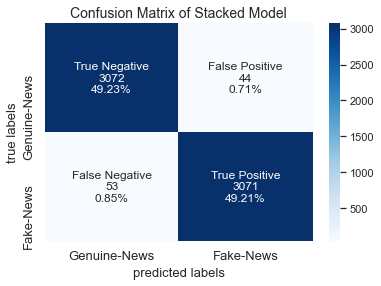

In [55]:
# visualizing confusion matrix  of Stacked Model with the help of heatmap.
ypred = stacked_model(predict=True).predict(xtest_vec) # predicting the test data
c_matric = confusion_matrix(ytest, ypred) # initailizing confusion matrix
groups = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in c_matric.flatten()]  # count for each cell of confusion matrix 
group_percent = ['{0:.2%}'.format(value) for value in c_matric.flatten()/np.sum(c_matric)]  # calculating percent in each cell
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(groups,group_counts,group_percent)] # organizing labels to plot on the confusion matrix
labels = np.asarray(labels).reshape(2,2)  # reshaping
sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues') # plotting heatmap
plt.title('Confusion Matrix of Stacked Model', fontsize = 14)  # setting title
plt.ylabel('true labels', fontsize = 13) # plotting x label
plt.xlabel('predicted labels', fontsize = 13) # plotting y label
fig, ax = plt.gcf(), plt.gca()
ax.set_xticklabels(['Genuine-News','Fake-News'], fontdict = {'fontsize':13}) # plotting x tick labels
ax.set_yticklabels(['Genuine-News','Fake-News'], fontdict = {'fontsize':13})  # plotting y tick labels
plt.show()

model: LinearSVC(C=1.3666666666666667, random_state=0)
CV score:0.9743818681318681
score_std: 0.001973915915274707
----------
model: MultinomialNB(alpha=0.01)
CV score:0.9297390109890111
score_std: 0.0033195181246138817
----------
model: RandomForestClassifier(n_estimators=250, random_state=3)
CV score:0.9721153846153847
score_std: 0.00384492719842812
----------
model: AdaBoostClassifier(learning_rate=1, n_estimators=150, random_state=0)
CV score:0.9773351648351648
score_std: 0.0019786896003966873
----------
model: StackingClassifier(cv=5,
                   estimators=[('LinearSVC',
                                LinearSVC(C=1.3666666666666667,
                                          random_state=0)),
                               ('Multinomial NB', MultinomialNB(alpha=0.01)),
                               ('Random Forest',
                                RandomForestClassifier(n_estimators=250,
                                                       random_state=3)),
            

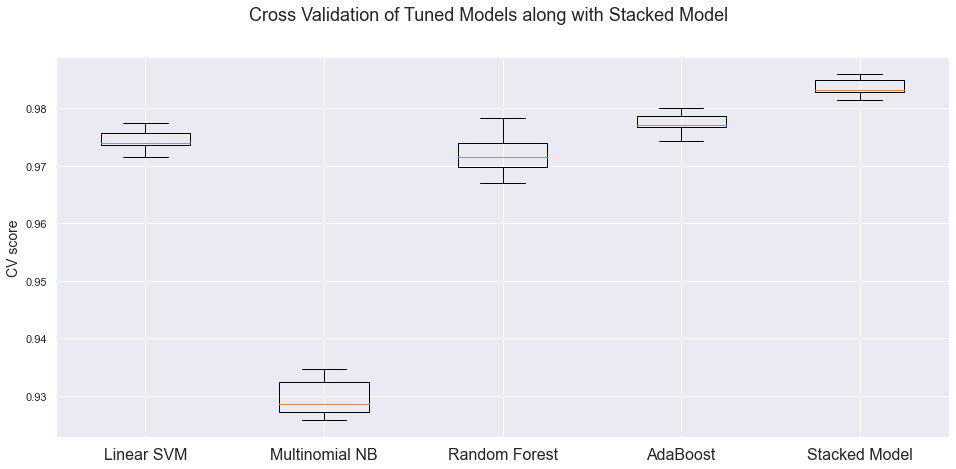

In [48]:
model_name = ['Linear SVM', 'Multinomial NB', 'Random Forest', 'AdaBoost','Stacked Model'] # model name
title = 'Cross Validation of Tuned Models along with Stacked Model' # title  of the plot
cross_validation(tuned_models + [stacked_model()], model_name,title) # computing cross-validation results